# Finetuning HuggingFace Vision Transformer with Custom Dataset

In [2]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 5.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.1
    Uninstalling matplotlib-3.6.1:
      Successfully uninstalled matplotlib-3.6.1


In [3]:
import torchvision
from torchvision.transforms import ToTensor
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
torch.__version__

'1.12.1'

In [5]:
!pip install -q git+https://github.com/huggingface/transformers

### Loading data and creating datasets

In [7]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.Resize((150,150)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_ds = torchvision.datasets.ImageFolder('data/plastic/train', transform=transform)
test_ds = torchvision.datasets.ImageFolder('data/plastic/test', transform=transform)

### Finetuning pretrained vit-base-patch16-224-in21k model

In [8]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
            return logits, loss.item()
        else:
            return logits, None

In [9]:
EPOCHS = 5
BATCH_SIZE = 10
LEARNING_RATE = 2e-4

In [28]:
labels = ['bottles', 'cans', 'sprays']

In [10]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch

# Define Model
model = ViTForImageClassification(len(train_ds.classes))

# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model training

In [12]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

# Train the model
for epoch in range(EPOCHS):
    for step, (x, y) in enumerate(train_loader):
        x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
        for index, array in enumerate(x):
            x[index] = np.squeeze(array)
        x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
        x, y  = x.to(device), y.to(device)
        b_x = Variable(x)
        b_y = Variable(y)
        output, loss = model(b_x, None)
        # Calculate loss
        if loss is None: 
            loss = loss_func(output, b_y)   
            optimizer.zero_grad()           
            loss.backward()                 
            optimizer.step()

        if step % 10 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss)

Number of train samples:  780
Number of test samples:  30
Detected Classes are:  {'bottles': 0, 'cans': 1, 'sprays': 2}
Epoch:  0 | train loss: 1.1196
Epoch:  0 | train loss: 0.4546
Epoch:  0 | train loss: 0.1524
Epoch:  0 | train loss: 0.0690
Epoch:  0 | train loss: 1.1545
Epoch:  0 | train loss: 0.1089
Epoch:  0 | train loss: 0.1731
Epoch:  0 | train loss: 0.4896
Epoch:  1 | train loss: 0.0474
Epoch:  1 | train loss: 0.0419
Epoch:  1 | train loss: 0.0607
Epoch:  1 | train loss: 0.0420
Epoch:  1 | train loss: 0.3447
Epoch:  1 | train loss: 0.1624
Epoch:  1 | train loss: 0.0372
Epoch:  1 | train loss: 0.0655
Epoch:  2 | train loss: 0.6340
Epoch:  2 | train loss: 0.7879
Epoch:  2 | train loss: 0.8784
Epoch:  2 | train loss: 0.5107
Epoch:  2 | train loss: 1.1252
Epoch:  2 | train loss: 0.6410
Epoch:  2 | train loss: 0.9133
Epoch:  2 | train loss: 0.2076
Epoch:  3 | train loss: 0.0432
Epoch:  3 | train loss: 0.0267
Epoch:  3 | train loss: 0.1507
Epoch:  3 | train loss: 0.2346
Epoch:  3 | 

In [18]:
torch.save(model.state_dict(), "data/plastic/models/vt_finetuned_v1.pth")

### Model Testing and Evaluation

In [15]:
test_ds_1 = torchvision.datasets.ImageFolder('data/plastic/test_images', transform=transform)

In [19]:
test_loader_1  = data.DataLoader(test_ds_1, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

In [20]:
test_1 = next(iter(test_loader_1))
test_1_x = test_1[0]
test_1_x = np.split(np.squeeze(np.array(test_1_x)), BATCH_SIZE)
for index, array in enumerate(test_1_x):
    test_1_x[index] = np.squeeze(array)

test_1_x = torch.tensor(np.stack(feature_extractor(test_1_x)['pixel_values'], axis=0))

test_1_x = test_1_x.to(device)
test_1_y = test_1[1].to(device)

test_output_1, loss_1 = model(test_1_x, test_1_y)
test_output_1 = test_output_1.argmax(1)
print(test_output_1)
print(test_1_y)

accuracy_ = (test_output_1 == test_1_y).sum().item() / BATCH_SIZE
print(' test accuracy: %.2f' % accuracy_)

tensor([0, 2, 0, 2, 1, 1, 2, 0, 1, 2])
tensor([0, 1, 0, 2, 1, 0, 2, 0, 1, 2])
 test accuracy: 0.80


In [23]:
def calculate_recognition_accuracy(predicted, actual):
    num_correct_predictions = np.sum(predicted == actual)
    recognition_acc = num_correct_predictions/len(actual)
    return recognition_acc

In [24]:
recog_acc = calculate_recognition_accuracy(np.array(test_output_1), np.array(test_1_y))

In [26]:
print(f'The recognition accuracy for the test images {recog_acc}')

The recognition accuracy for the test images 0.8


In [30]:
cm = confusion_matrix(test_1_y, test_output_1)

In [37]:
from collections import Counter

test_labels = np.array(test_1_y)
act_dict = Counter(list(test_labels))
pred_list = cm.diagonal()
        
for i in range(len(labels)):
    label_recog = 100 * pred_list[i] / act_dict[i]
    print('Accuracy of', labels[i], label_recog)      

Counter({0: 4, 1: 3, 2: 3})
Accuracy of bottles 75.0
Accuracy of cans 66.66666666666667
Accuracy of sprays 100.0


<AxesSubplot:>

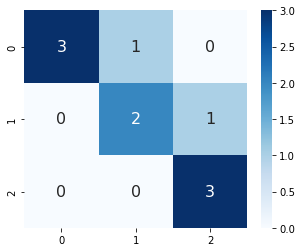

In [38]:
plt.figure(figsize = (5,4))
sn.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 16})